In [2]:
# Standard Dependencies
import cv2
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow Dependencies
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
# End Result
# Model(input = [inputImage,verificationImage] , output = [0,1])

In [4]:
# Set GPU Growth ( For GPU Based Machines )

# Avoid OOM errors by setting the GPU Memory consuption growth

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
len(gpus)  # this 0 zero length is saying that My machine doesn't have any GPu

0

In [6]:
# To create Folder Using OS

POS_PATH = os.path.join("data", "postive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [7]:
# Uncompress Tar GZ Labelled Faces
# !tar -xf lfw.tgz

In [8]:
# Move LFW Images to the Negative Repository (data/negative).

# for directory in os.listdir("lfw"):
#     for file in os.listdir(os.path.join("lfw", directory)):
#         EX_PATH = os.path.join("lfw", directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [9]:
# For generating Unique Id for the Image
import uuid

In [10]:
# Establish a Connection to the WebCam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120 : 120 + 250, 160 : 160 + 250, :]

    cv2.imshow("Image Collection", frame)

    # Anchor Collection
    if cv2.waitKey(1) & 0xFF == ord("a"):
        # Create a unique Image name
        imagName = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))

        # Save the Image
        cv2.imwrite(imagName, frame)

    # Positive Collection
    if cv2.waitKey(1) & 0xFF == ord("p"):
        # Create a unique Image name
        imagName = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))

        # Save the Image
        cv2.imwrite(imagName, frame)

    # Show image back to the Screen
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the WebCam
cap.release()
# Close the Image show Frame
cv2.destroyAllWindows()

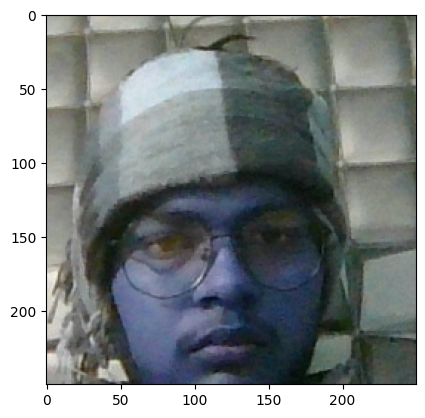

In [11]:
plt.imshow(frame)

In [12]:
# plt.imshow(frame[120 : 120 + 250, 160 : 160 + 250, :])

In [13]:
# Get Image Directories

anchor = tf.data.Dataset.list_files(ANC_PATH + "\\*.jpg").take(300)
postive = tf.data.Dataset.list_files(POS_PATH + "\\*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + "\\*.jpg").take(300)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [16]:
anchor.map(preprocess)

<_MapDataset element_spec=TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None)>

In [17]:
# Labelled Dataset

# (anchor , positive) => 1,1,1,1,1,1,.....
# (anchor , negative) => 0,0,0,0,0,0,.....

In [18]:
positives = tf.data.Dataset.zip(
    (anchor, postive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))
)
negatives = tf.data.Dataset.zip(
    (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))
)

In [19]:
data = positives.concatenate(negatives)

In [20]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [21]:
samples = data.as_numpy_iterator()

In [22]:
samples.next()

(b'data\\anchor\\9fd4790e-cb2c-11ef-81cd-bce92feafdf8.jpg',
 b'data\\postive\\756d6147-cb2c-11ef-ae50-bce92feafdf8.jpg',
 1.0)

In [23]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [24]:
# Building Dataloader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [25]:
# Training partition
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))

In [27]:
inp = Input(shape=(100, 100, 3), name="Input_image")
inp

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=False, name=Input_image>

In [28]:
# Build embedding Layer
def make_embedding():
    inp = Input(shape=(100, 100, 3), name="input_image")

    # First Block
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)

    # Second Block
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)

    # Third Block
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)

    # Final Embedding Block
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)

    return Model(inputs=inp, outputs=d1, name="embedding")

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Building Distance Layer


class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [32]:
# Making Siamese Model
def make_siamese_model():

    # Handle Inputs
    # Anchor Image in the Network
    input_img = Input(name="input_img", shape=(100, 100, 3))
    # Validation Image in the Network
    validation_img = Input(name="validation_img", shape=(100, 100, 3))

    # Embedding Outputs
    embedding_output1 = embedding(input_img)
    embedding_output2 = embedding(validation_img)

    # Combining Siamese Distance Components
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding_output1, embedding_output2)

    # Classification Layer
    classifier = Dense(1, activation="sigmoid")(distances)

    return Model(
        inputs=[input_img, validation_img], outputs=[classifier], name="SiameseNetwork"
    )

In [33]:
siamese_model = make_siamese_model()

In [34]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Training

In [36]:
# Setup Loss Function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [37]:
opt = tf.keras.optimizers.Adam(1e-4)

In [38]:
# Extablishing Checkpoint
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [50]:
# Build Train Step Function
@tf.function
def train_step(batch):
    # Recording All the operations.
    with tf.GradientTape() as tape:
        # Get anchor and Postives/Negative images
        X = batch[:2]
        # Get labels
        y = batch[2]

        # Forward Pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    # Calculate Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese_model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Returning Loss
    return loss

In [51]:
# Traing Loop
def train(data, EPOCHS):
    # Loop through Epochs
    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch in data
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx + 1)

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [52]:
EPOCHS = 50

In [ ]:
train(train_data,EPOCHS)